In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from tqdm import tqdm

In [3]:
# Load Data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Data Cleaning

In [4]:
months = ['January', 'February', 'March',
          'April', 'May', 'June', 'July',
          'August', 'September', 'October',
          'November', 'December']
def classify_month(x):
    return months.index(x) // 3

from nltk import word_tokenize
from nltk import pos_tag

# Tokenize Property type, get nouns in order to reduce unique categories
keys = np.unique(np.concatenate([train['Property_type'],test['Property_type']]))
vals = [[w[0] for w in pos_tag([word for word in word_tokenize(doc.lower().replace('/',' ')) if word.isalpha()]) if w[1] == 'NN' and w[0] != 'room'] for doc in keys]
uni_vals = np.unique(['room'] + [' '.join(v) for v in vals])

val_dict = {}
for i, v in enumerate(uni_vals):
    val_dict[v] = i

property_dict = {}
for i, k in enumerate(keys):
    if len(vals[i]) == 0:
        property_dict[k] = val_dict['room']
    else:
        property_dict[k] = val_dict[' '.join(vals[i])]

# Tokenize Bathroom type, get nouns in order to reduce unique categories

def clean_bathroom(X):
    clean = [[w[0] for w in pos_tag(word_tokenize(doc.lower())) if w[1] == 'CD' or w[1] == 'NN' or w[1] == 'NNS'] for doc in X]
    return [0.5 if len(doc) == 1 else doc[0] for doc in clean] #map half-bath to 0.5

key = np.concatenate([train['Bathrooms_text'].unique(), test['Bathrooms_text'].unique()])
bath = clean_bathroom(key)

bath_dict = {}
for i, k in enumerate(key):
    bath_dict[k] = bath[i]

def CLEAN_ALL(inp, train = True, exclude_columns = ['id']):
    X_train = inp.copy()
    
    if train:
        X_train, y_train = X_train.drop('Decision', axis = 1), X_train['Decision']

    # DATA CLEANING
    if 'Price' not in exclude_columns:
        X_train['Price'] = X_train['Price'].apply(lambda x: float(x.replace('$','').replace(',','')))
        
    if 'Host_response_time' not in exclude_columns:
        X_train['Host_response_time'] = X_train['Host_response_time'].apply(lambda x: 0 if x == 'within an hour' else (1 if x == 'within a few hours' else (2 if x == 'within a day' else (3 if x == 'a few days or more' else x))))
    
    if 'Host_is_superhost' not in exclude_columns:
        X_train['Host_is_superhost'] = X_train['Host_is_superhost'].apply(lambda x: 1 if x == 't' else (0 if x == 'f' else x))
    
    if 'Host_has_profile_pic' not in exclude_columns:
        X_train['Host_has_profile_pic'] = X_train['Host_has_profile_pic'].apply(lambda x: 1 if x == 't' else (0 if x == 'f' else x))
    
    if 'Host_identity_verified' not in exclude_columns:
        X_train['Host_identity_verified'] = X_train['Host_identity_verified'].apply(lambda x: 1 if x == 't' else (0 if x == 'f' else x))
    
    if 'Instant_bookable' not in exclude_columns:
        X_train['Instant_bookable'] = X_train['Instant_bookable'].apply(lambda x: 1 if x == 't' else (0 if x == 'f' else x))
    
    if 'Bathrooms_text' not in exclude_columns:
        X_train['Bathrooms_text'] = X_train['Bathrooms_text'].apply(lambda x: float(bath_dict[x]))

    if 'Property_type' not in exclude_columns:
        X_train['Property_type'] = X_train['Property_type'].apply(lambda x: property_dict[x])
    
    if 'Room_type' not in exclude_columns:
        X_train['Room_type'] = X_train['Room_type'].apply(lambda x: 0 if x == 'Entire home/apt' else (1 if x == 'Private room' else (2 if x == 'Hotel room' else 3)))

    if 'Month' not in exclude_columns:
        X_train['Month'] = X_train['Month'].apply(lambda x: classify_month(x))
    
    for col in exclude_columns:
        X_train = X_train.drop(col, axis = 1)
        
    if train:
        return X_train, y_train
    else:
        return X_train

In [22]:
# Use KNNImputer to fill in null values
# Standardize mean + variance
pipeline = make_pipeline(KNNImputer(n_neighbors = 10), StandardScaler())
X,y = CLEAN_ALL(train)
columns = X.columns
X = pipeline.fit_transform(X)

# Cross Validation over Regularization Coefficient

In [25]:
accs = np.zeros((50, 5))
for i, d in enumerate(tqdm(np.arange(0.2, 10.2, 0.2))):
    rf = LogisticRegression(multi_class = 'multinomial', C = d)
    cv_results = cross_validate(rf, X, y)
    accs[i] = cv_results['test_score']

100%|██████████| 50/50 [00:04<00:00, 12.18it/s]


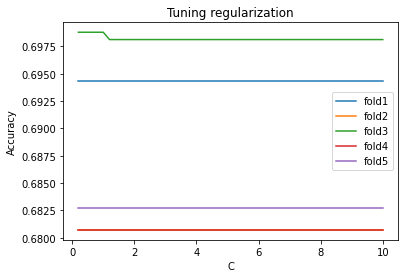

In [27]:
plt.plot(np.arange(0.2, 10.2, 0.2), accs)

plt.legend(labels = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5'])
plt.title('Tuning regularization')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.show()

# Cross Validation over Backwards Selection

100%|██████████| 19/19 [00:13<00:00,  1.36it/s]


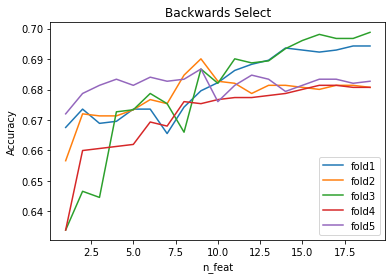

In [8]:
accs = np.zeros((19, 5))
for n_feat in tqdm(range(1,20)):
    selector = RFE(LogisticRegression(multi_class = 'multinomial'), n_features_to_select = n_feat, step=1)
    cv_results = cross_validate(selector, X, y)
    accs[n_feat-1] = cv_results['test_score']
    
plt.plot(range(1, 20), accs)
plt.legend(labels = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5'])
plt.title('Backwards Select')
plt.xlabel('n_feat')
plt.ylabel('Accuracy')

plt.show()

In [9]:
from yellowbrick.regressor import CooksDistance
from yellowbrick.regressor import ResidualsPlot

In [10]:
def CooksD(scaledX, y):
    visualizer = CooksDistance()
    visualizer.fit(scaledX, y)
    visualizer.show()

## Multicollinearity & Logistics

In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE

Let's observe the VIF in order to check for multicollinearity. VIF < 10 should be acceptable.

In [23]:
def VIF(X_):
    vif = pd.DataFrame()
    vif['variables'] = columns
    vif['VIF'] = [variance_inflation_factor(X_, i) for i in range(20)]
    return vif

In [24]:
VIF(X)

,variables,VIF
0,Host_response_time,1.160336
1,Host_is_superhost,1.170075
2,Host_has_profile_pic,1.009112
3,Host_identity_verified,1.048332
4,Neighbourhood,1.048340
5,Property_type,1.064285
6,Room_type,1.226151
7,Accommodates,6.731079
8,Bathrooms_text,3.408093
9,Bedrooms,5.798953


Let's observe the Cook's Distance in order to observe highly influential points:

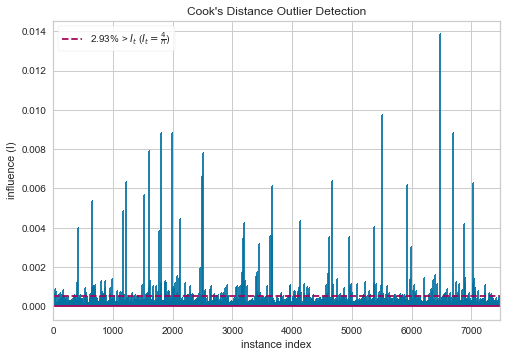

In [190]:
CooksD(scaledX, y)

Only 2.93% of points are considered influential; not enough to influence our model greatly.

# Final Model

In [27]:
clf = LogisticRegression(multi_class = 'multinomial')
cv_results = cross_validate(clf, X, y, return_estimator = True)
print('Fold Accuracies: ' + str(cv_results['test_score']))

Fold Accuracies: [0.69431438 0.68072289 0.69879518 0.68072289 0.68273092]


In [28]:
model = cv_results['estimator'][2]

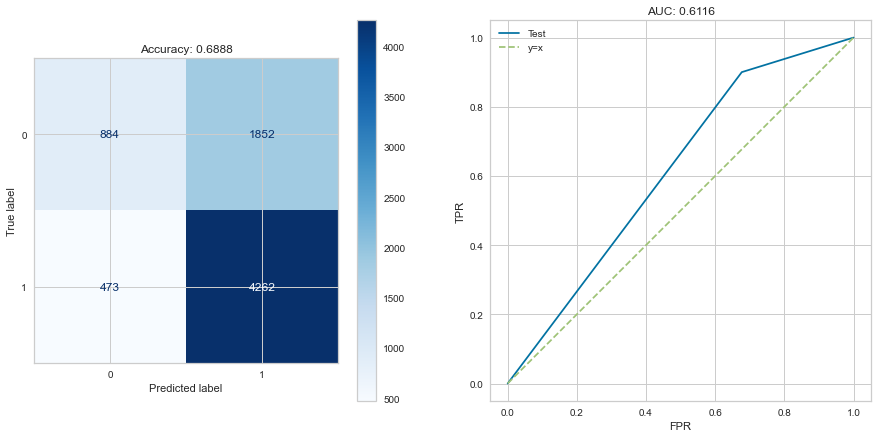

In [29]:
fig, axs = plt.subplots(1, 2, figsize = (15, 7))

test_pred = model.predict(X)
cm = confusion_matrix(y, test_pred, labels = model.classes_)#, normalize = 'true')
disp = ConfusionMatrixDisplay(
    confusion_matrix = cm,
    display_labels = model.classes_
)
disp.plot(cmap =  plt.cm.Blues, ax = axs[0])

axs[0].set(title = 'Accuracy: ' + str(round(np.sum(test_pred == y)/len(y),5)))

te_fpr, te_tpr, thresh = roc_curve(y, test_pred)

axs[1].plot(te_fpr, te_tpr)
axs[1].plot([0,1],[0,1],'--')
axs[1].legend(labels = ['Test', 'y=x'])
axs[1].set(title = 'AUC: ' + str(round(auc(te_fpr, te_tpr), 5)), 
           xlabel = 'FPR', ylabel = 'TPR')

plt.show()